### Analyzing the careful attack in practice




In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
RESULTS_LOCATION  = '../../../../data/results/'

In [3]:
RESULTS_FILES = ['careful_iterations=887_samples=900083_scalefunc=K_0_delta=500_centroids=346_sizeBytes=5568_impl=merging_alt_false.csv',
 'careful_iterations=890_samples=2413634_scalefunc=K_0_delta=500_centroids=350_sizeBytes=4232_impl=tree.csv',
 'careful_iterations=889_samples=1038262_scalefunc=K_0_delta=500_centroids=348_sizeBytes=5600_impl=merging_alt_true.csv']

In [4]:
class TDigestComparisonPlot(object):
    
    def __init__(self, f, error='TD abs. error'):
        self.filename = f
        self.error = error
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]

    def _set_df(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.df = pd.read_csv(f, header=0, sep=';')
        
    def plot_data(self):
        self._set_df()
        # TODO: add KLL columns
        plt.plot(self.df['true quantile'][:200], self.df[self.error][:200], label=self.readable_name())
        

In [5]:
SORTED_RESULTS_FILES = ['careful_iterations=887_samples=900083_scalefunc=K_0_delta=500_centroids=304_sizeBytes=4896_impl=merging_alt_false_sorted.csv',
'careful_iterations=889_samples=1038262_scalefunc=K_0_delta=500_centroids=307_sizeBytes=4944_impl=merging_alt_true_sorted.csv',
'careful_iterations=890_samples=2413634_scalefunc=K_0_delta=500_centroids=315_sizeBytes=3812_impl=tree_sorted.csv']

In [6]:
def display(res_files):
    digests = [TDigestComparisonPlot(f) for f in res_files]
    for t in digests:
        t.plot_data()

    plt.legend()
    plt.xlabel('quantile')
    plt.ylabel('error')
    plt.show()

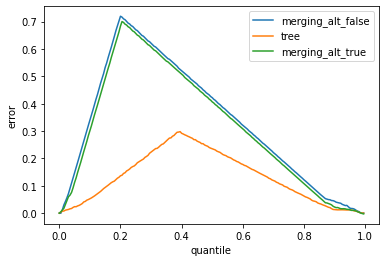

In [7]:
display(RESULTS_FILES)

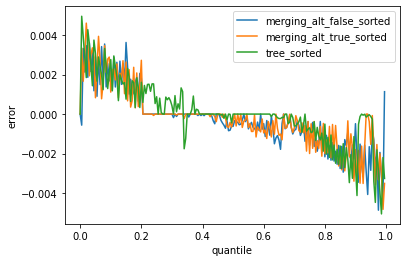

In [8]:
display(SORTED_RESULTS_FILES)

### Local overlap computation

Given a $t$-digest $\{ C_1, \ldots, C_n \}$, we compute the function mapping a centroid $C_i$ to the Kolmogorov-Smirnov statistic of the sets underlying $C_i$ and $C_{i+1}$, i.e., a measure of the overlap between neighborhood centroids. The K-S statistic ranges from $0$ (limit of the completely mixed case) to $1$ (completely separated case), and we may view a centroid as occupying an interval quantile space, hence the mapping may be viewed as a function from the unit interval to itself.

In [9]:
class CentroidOverlapComputation(object):
    
    def __init__(self, f):
        self.filename = f
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]
    
    def _get_counts(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.centroids = [[float(y) for y in line.rstrip('\n').split(',') if len(y) > 0] for line in f.readlines()]
        
    def _verify_total_count(self):
        self.counts = [len(x) - 1 for x in self.centroids]
        self.total_count = sum(self.counts)
        assert('samples={}'.format(self.total_count) in self.filename)

    def _compute_ks_stats(self):
        self.ks = []
        for idx in range(len(self.centroids) - 1):
            centroid = self.centroids[idx][1:]
            next_centroid = self.centroids[idx + 1][1:]
            self.ks.append(ks_2samp(centroid, next_centroid)[0])

    def _compute_cum_norm_weight(self):
        q = [count / self.total_count for count in self.counts]
        self.cum_weight = [sum(q[:i + 1]) for i in range(len(q))]
        
    def plot(self):
        assert(len(self.ks) == len(self.cum_weight) - 1)
        plt.plot(self.cum_weight[:-1], self.ks, label=self.readable_name())
        
    def prepare(self):
        self._get_counts()
        self._verify_total_count()
        self._compute_ks_stats()
        self._compute_cum_norm_weight()

In [10]:
def display_ks_curves(res_files):
    cents = [CentroidOverlapComputation(f) for f in res_files]
    for c in cents:
        c.prepare()
        c.plot()
        
    plt.legend()
    plt.xlabel('cumulative centroid weight')
    plt.ylabel('local KS statistic')
    plt.show()

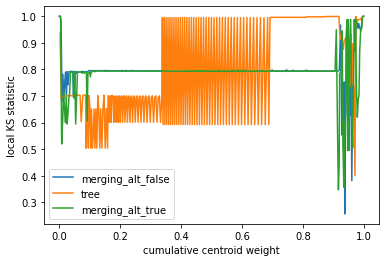

In [12]:
display_ks_curves(['centroids_' + x for x in RESULTS_FILES])

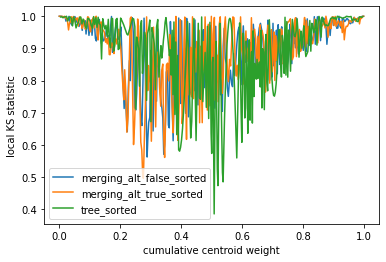

In [13]:
display_ks_curves(['centroids_' + x for x in SORTED_RESULTS_FILES])

In [ ]:
# TODO add option to savefig, other plots